In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0, "../0.data-download/scripts/")
from data_loader import load_data, load_train_test_data

In [2]:
# data path
data_directory = "../0.data-download/data/"

In [3]:
# load the training data
dfs_test, dfs, data = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=False
)

In [4]:
# set a unique dataframe that can be appended from
training_df_age = dfs

# group by age and create new dataframes that can be appended to
groups = training_df_age.groupby("age_and_sex")
adult_effect_df = pd.DataFrame()
ped_effect_df = pd.DataFrame()
for name, training_df_age in groups:

    # append rows that contain Adult samples (male or female) to the new adult effect dataframe
    if name == "Adult_Male" or name == "Adult_Female" or name == "Adult_nan":
        adult_effect_df = adult_effect_df._append(training_df_age)
        adult_effect_df = adult_effect_df.reset_index(drop=True)

    # append rows that contain Pediatric samples (male ore female) to the new pediatric dataframe
    else:
        ped_effect_df = ped_effect_df._append(training_df_age)
        ped_effect_df = ped_effect_df.reset_index(drop=True)

In [5]:
# set a unique dataframe that can be appended from
training_df_sex = dfs

# group by sex and create new dataframes to be appended to
groups_sex = training_df_sex.groupby("age_and_sex")
male_effect_df = pd.DataFrame()
female_effect_df = pd.DataFrame()
for name, training_df_sex in groups_sex:

    # append rows that contain Male samples (Adult or Pediatric) to the new male effect dataframe and filter out samples that contain no gender info
    if (
        name == "Adult_Male"
        or name == "Pediatric_Male"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        male_effect_df = male_effect_df._append(training_df_sex)
        male_effect_df = male_effect_df.reset_index(drop=True)

    # append rows that contain Female samples (Adult or Pediatric) to the new female effect dataframe and filter out samples that contain no gender info
    elif (
        name == "Adult_Female"
        or name == "Pediatric_Female"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        female_effect_df = female_effect_df._append(training_df_sex)
        female_effect_df = female_effect_df.reset_index(drop=True)

In [6]:
print(adult_effect_df.shape)
adult_effect_df.head(3)

(116, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000348,-0.083439,-0.039894,0.010377,0.113985,-0.285410,-0.079495,0.036602,-0.063939,-0.034673,...,-0.545069,0.013269,-0.196753,0.114824,-0.077060,-0.137285,-0.147227,-0.035045,-0.197649,Adult_Female
1,ACH-001041,-0.203043,0.011560,0.056424,0.158041,-0.196482,-0.028753,0.001179,-0.226252,-0.024476,...,-0.879321,0.078645,0.115316,-0.208417,-0.108645,0.027639,-0.109669,-0.273492,-0.171996,Adult_Female
2,ACH-002023,-0.034388,-0.056414,0.104747,0.105189,-0.110508,-0.033761,-0.015249,-0.287524,0.075372,...,-0.488110,0.039945,0.118285,-0.188037,-0.094378,-0.129804,-0.057752,-0.042228,-0.491358,Adult_Female


In [7]:
print(ped_effect_df.shape)
ped_effect_df.head(3)

(21, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000884,-0.063601,-0.111586,-0.034173,0.169218,0.006084,-0.189399,0.057840,-0.206656,0.036632,...,-0.980442,0.099148,-0.046957,0.012013,0.128798,-0.062086,-0.126956,-0.008040,-0.342260,Adult_Unknown
1,ACH-000082,-0.134269,-0.004772,0.036335,0.181331,-0.441556,-0.001539,0.122407,-0.237189,-0.030824,...,-0.764546,0.194079,0.213967,0.031791,-0.033478,-0.108154,-0.063531,-0.086975,-0.516250,Pediatric_Female
2,ACH-001421,-0.077136,-0.002465,0.129250,0.209968,-0.264680,-0.108559,0.052807,-0.315079,0.061862,...,-0.847455,-0.119510,0.110203,0.079277,-0.048616,-0.241578,-0.044542,-0.250670,-0.396274,Pediatric_Female


In [8]:
print(male_effect_df.shape)
male_effect_df.head(3)

(77, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-002250,-0.005836,-0.061905,0.088103,0.195285,-0.343603,0.047670,0.112864,-0.248653,-0.015111,...,-0.889710,0.035355,0.163789,0.039258,-0.007928,-0.075173,-0.074534,-0.227281,-0.149779,Adult_Male
1,ACH-000090,0.094600,-0.206399,-0.098491,-0.097645,-0.158339,0.123068,0.029908,0.455524,0.246956,...,-0.414728,-0.252734,-0.378300,-0.057818,0.206900,-0.254824,-0.223992,-0.161450,-0.607456,Adult_Male
2,ACH-000878,-0.206538,-0.004134,0.076969,-0.061892,-0.171510,-0.016525,-0.174509,-0.144320,-0.007792,...,-0.079503,0.085041,0.133364,-0.036145,0.172871,-0.140995,0.145191,-0.144046,-0.165440,Adult_Male


In [9]:
print(female_effect_df.shape)
female_effect_df.head(3)

(58, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000348,-0.083439,-0.039894,0.010377,0.113985,-0.285410,-0.079495,0.036602,-0.063939,-0.034673,...,-0.545069,0.013269,-0.196753,0.114824,-0.077060,-0.137285,-0.147227,-0.035045,-0.197649,Adult_Female
1,ACH-001041,-0.203043,0.011560,0.056424,0.158041,-0.196482,-0.028753,0.001179,-0.226252,-0.024476,...,-0.879321,0.078645,0.115316,-0.208417,-0.108645,0.027639,-0.109669,-0.273492,-0.171996,Adult_Female
2,ACH-002023,-0.034388,-0.056414,0.104747,0.105189,-0.110508,-0.033761,-0.015249,-0.287524,0.075372,...,-0.488110,0.039945,0.118285,-0.188037,-0.094378,-0.129804,-0.057752,-0.042228,-0.491358,Adult_Female


In [10]:
# drop the string values from all dataframes
adult_effect_df_float = adult_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)
ped_effect_df_float = ped_effect_df.drop(columns=["ModelID", "age_and_sex"])

male_effect_df_float = male_effect_df.drop(columns=["ModelID", "age_and_sex"])
female_effect_df_float = female_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)

effect_df = dfs.drop(columns="age_and_sex")
effect_df = effect_df.set_index("ModelID")

In [11]:
# t_test comparing gene dependencies in adult vs pediatric samples
t_test = ttest_ind(adult_effect_df_float, ped_effect_df_float)
t_test = pd.DataFrame(t_test).T
t_test.columns = ["t_stat", "p_value"]
print(t_test.shape)
t_test.head(3)

(17202, 2)


,t_stat,p_value
0,0.607504,0.544537
1,-0.466634,0.641514
2,2.703235,0.007750


In [12]:
# t_test comparing gene dependencies in male vs female samples
t_test_sex = ttest_ind(male_effect_df_float, female_effect_df_float)
t_test_sex = pd.DataFrame(t_test_sex).T
t_test_sex.columns = ["t_stat", "p_value"]
print(t_test_sex.shape)
t_test_sex.head(3)

(17202, 2)


,t_stat,p_value
0,0.390109,0.697080
1,1.131485,0.259887
2,1.647022,0.101914


In [13]:
print(effect_df.shape)
effect_df.head(3)

(137, 17202)


,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-000348,-0.083439,-0.039894,0.010377,0.113985,-0.285410,-0.079495,0.036602,-0.063939,-0.034673,-0.023149,...,-0.081173,-0.545069,0.013269,-0.196753,0.114824,-0.077060,-0.137285,-0.147227,-0.035045,-0.197649
ACH-001041,-0.203043,0.011560,0.056424,0.158041,-0.196482,-0.028753,0.001179,-0.226252,-0.024476,0.213214,...,-0.178219,-0.879321,0.078645,0.115316,-0.208417,-0.108645,0.027639,-0.109669,-0.273492,-0.171996
ACH-002250,-0.005836,-0.061905,0.088103,0.195285,-0.343603,0.047670,0.112864,-0.248653,-0.015111,0.148899,...,-0.096178,-0.889710,0.035355,0.163789,0.039258,-0.007928,-0.075173,-0.074534,-0.227281,-0.149779


In [14]:
# calculate variance of each gene then send the results plus the gene info into a new dataframe
variance = effect_df.var()
variance_list = variance.tolist()
column_names = ["variance"]
variance_df = pd.DataFrame(variance, columns=column_names)
variance_df = variance_df.sort_index(ascending=True).reset_index()
variance_df = variance_df.rename(columns={"index": "gene_ID"})
print(variance_df.shape)
variance_df.head(3)

(17202, 2)


,gene_ID,variance
0,A1BG (1),0.009725
1,A1CF (29974),0.011696
2,A2M (2),0.010187


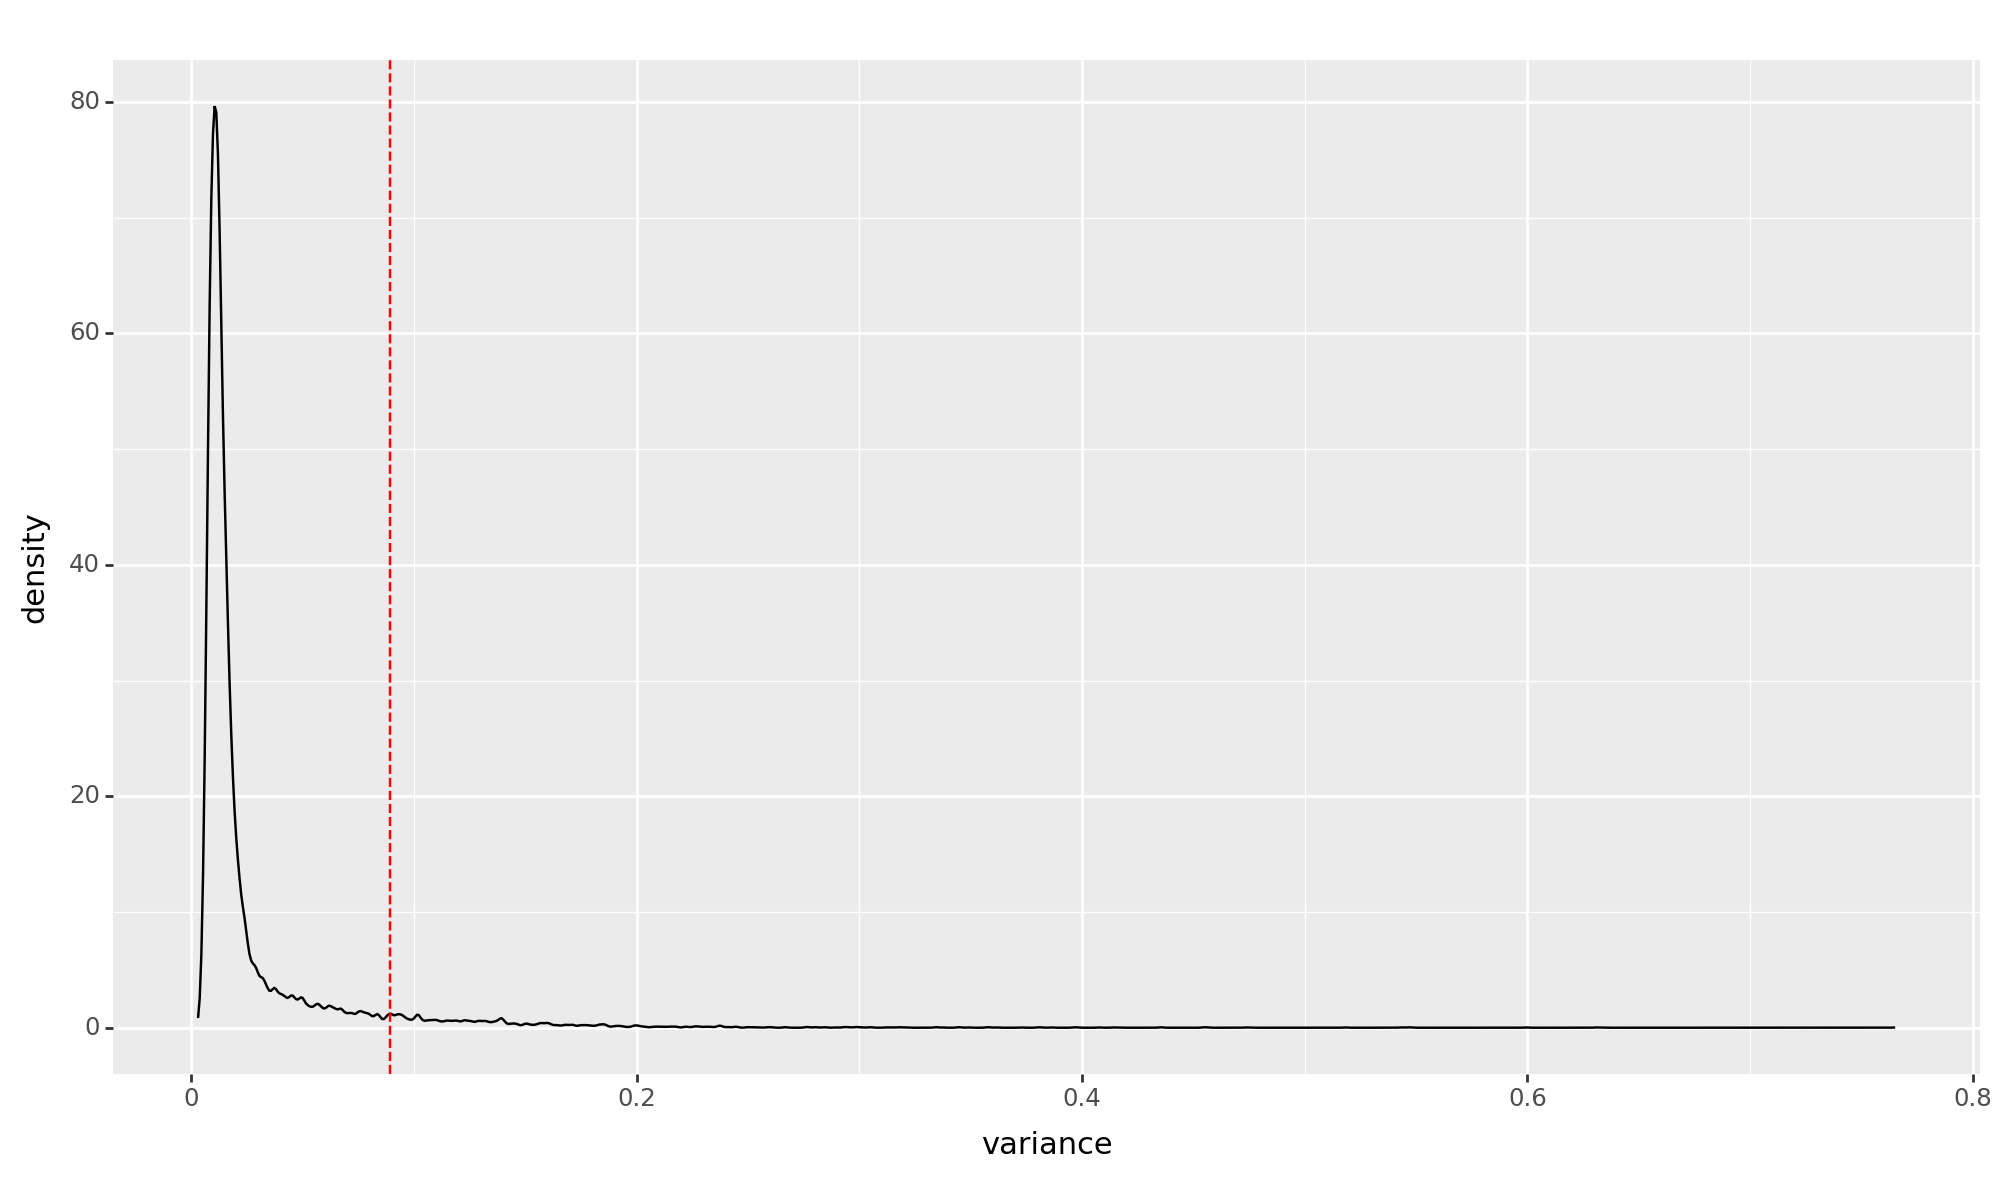

<Figure Size: (1000 x 600)>

In [15]:
# finding the smallest gene variation out of the 1000 largest gene variations to set the top 1000 gene variances threshold
n = variance_df["variance"].nlargest(1000)
variance_theshold = n.astype(float).min()

# plotting variance density chart and marking the 1000 largest gene variation cutoff
variance_density_plot = (
    p9.ggplot(variance_df, p9.aes(x="variance"))
    + p9.geom_density()
    + p9.geom_vline(xintercept=variance_theshold, linetype="dashed", color="red")
    + p9.theme(figure_size=(10, 6))
)

# save the figure
density_path = pathlib.Path("./figures/variance_density_plot.png")
variance_density_plot.save(density_path)
variance_density_plot

In [16]:
# first create new dataframe containing gene info as well as both adult-pediatric and male-female t-test results and variance results
df = variance_df.assign(
    ttest_A_vs_P=t_test.t_stat.astype(float),
    ttest_M_vs_F=t_test_sex.t_stat.astype(float),
)

# and save the new dataframe as a .csv
testing_df_output = pathlib.Path(
    "../0.data-download/data/genes_variances_and_t-tests_df.csv"
)
df.to_csv(testing_df_output, index=False)
print(df.shape)
df.head(3)

(17202, 4)


,gene_ID,variance,ttest_A_vs_P,ttest_M_vs_F
0,A1BG (1),0.009725,0.607504,0.390109
1,A1CF (29974),0.011696,-0.466634,1.131485
2,A2M (2),0.010187,2.703235,1.647022


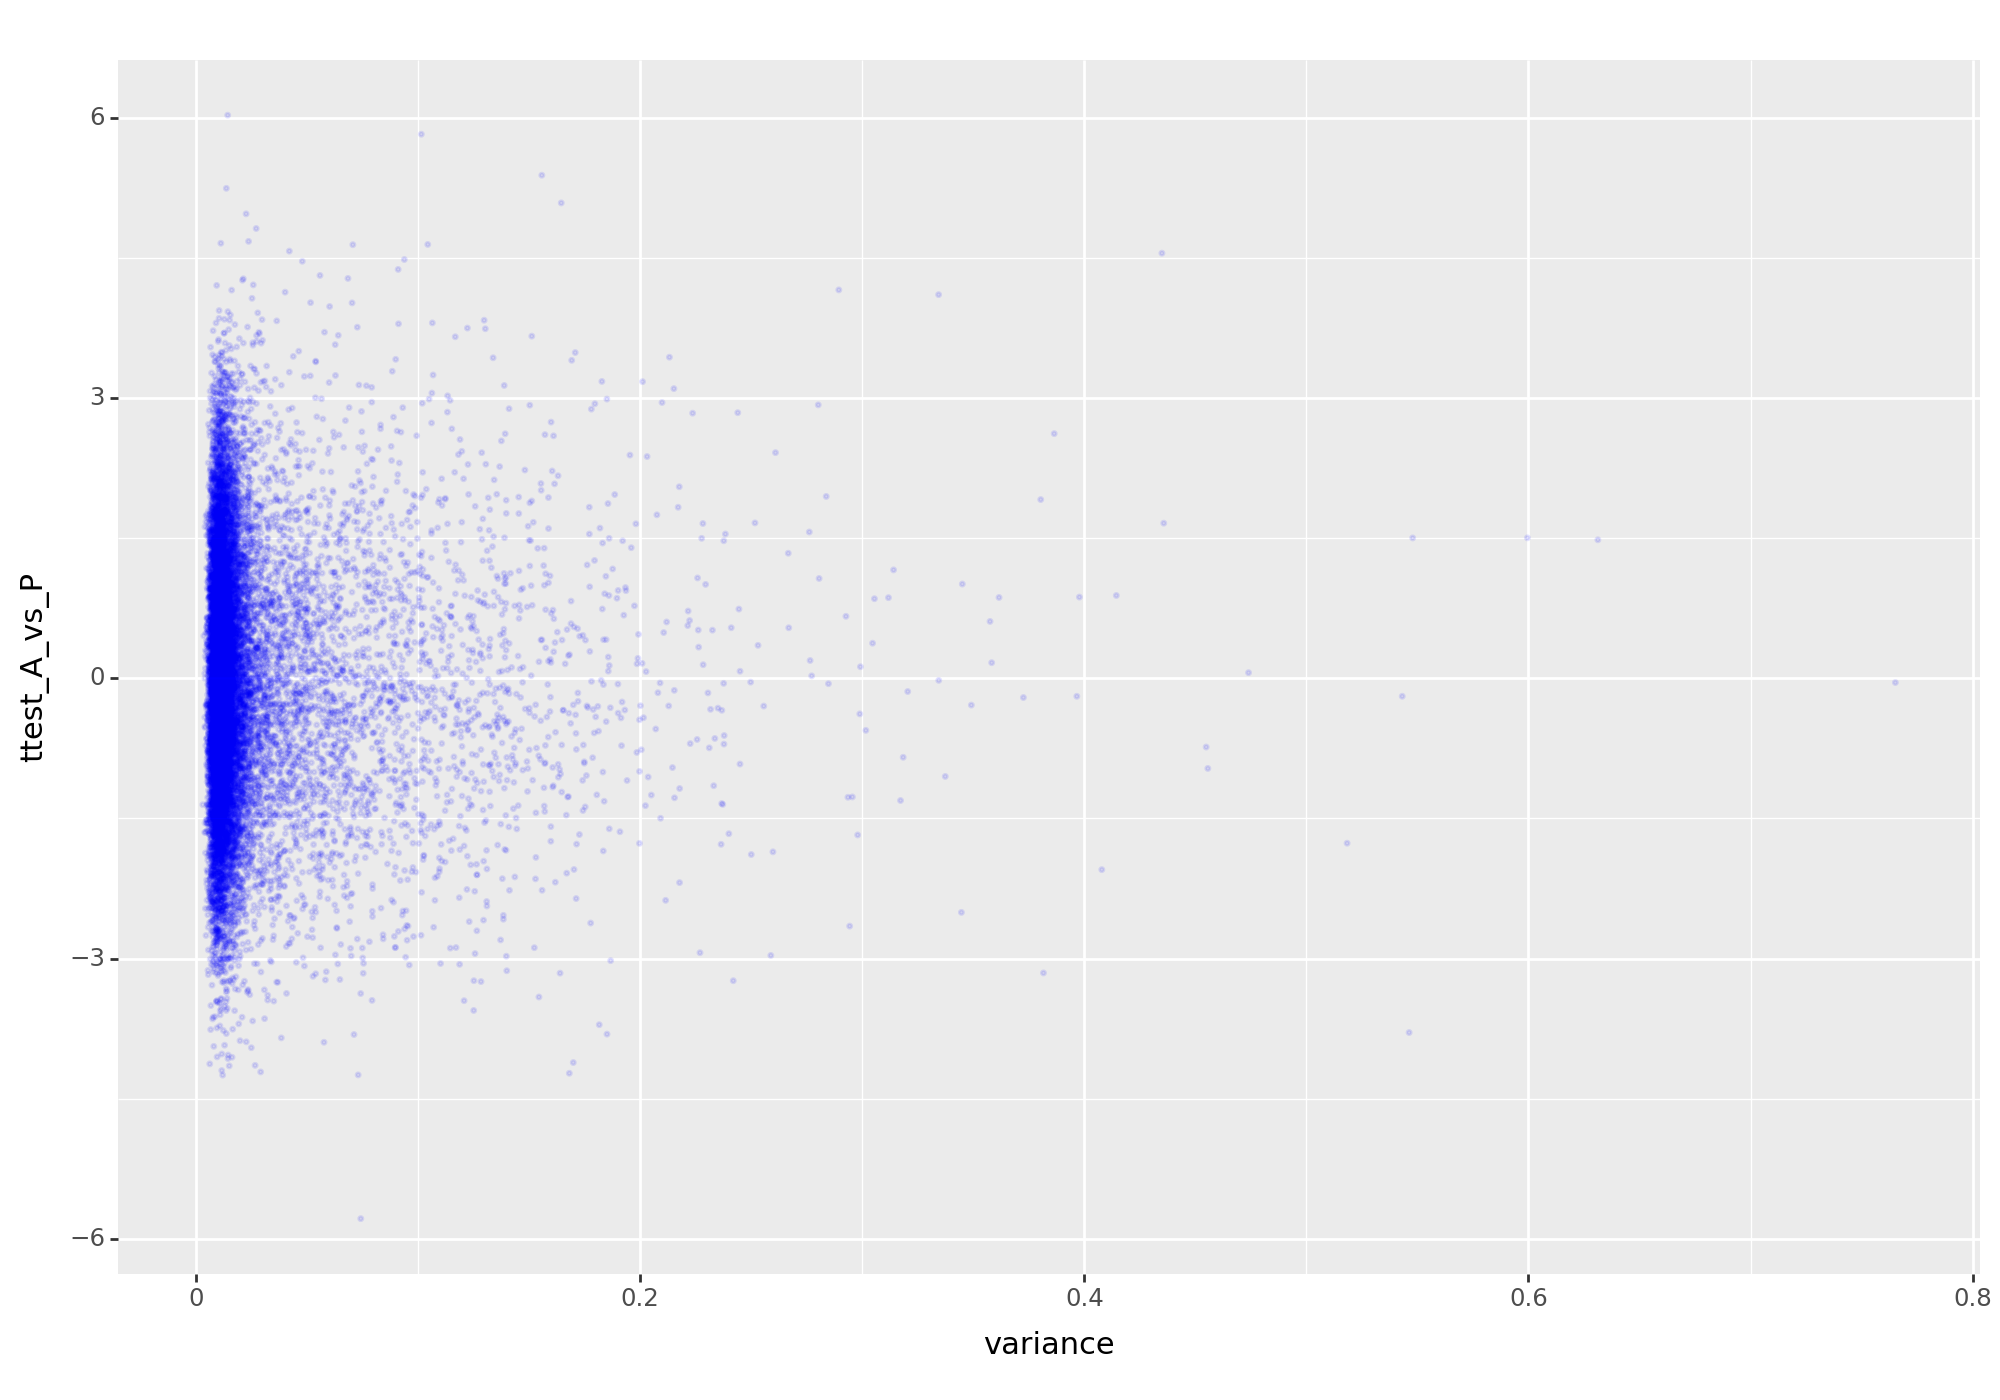

<Figure Size: (1000 x 700)>

In [17]:
# plot adult-pediatric ttest versus variance
A_vs_P_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_A_vs_P"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
adult_vs_pediatric_path = pathlib.Path(
    "./figures/adult-pediatric_ttest_vs_variance.png"
)
A_vs_P_by_variance_plot.save(adult_vs_pediatric_path)
A_vs_P_by_variance_plot

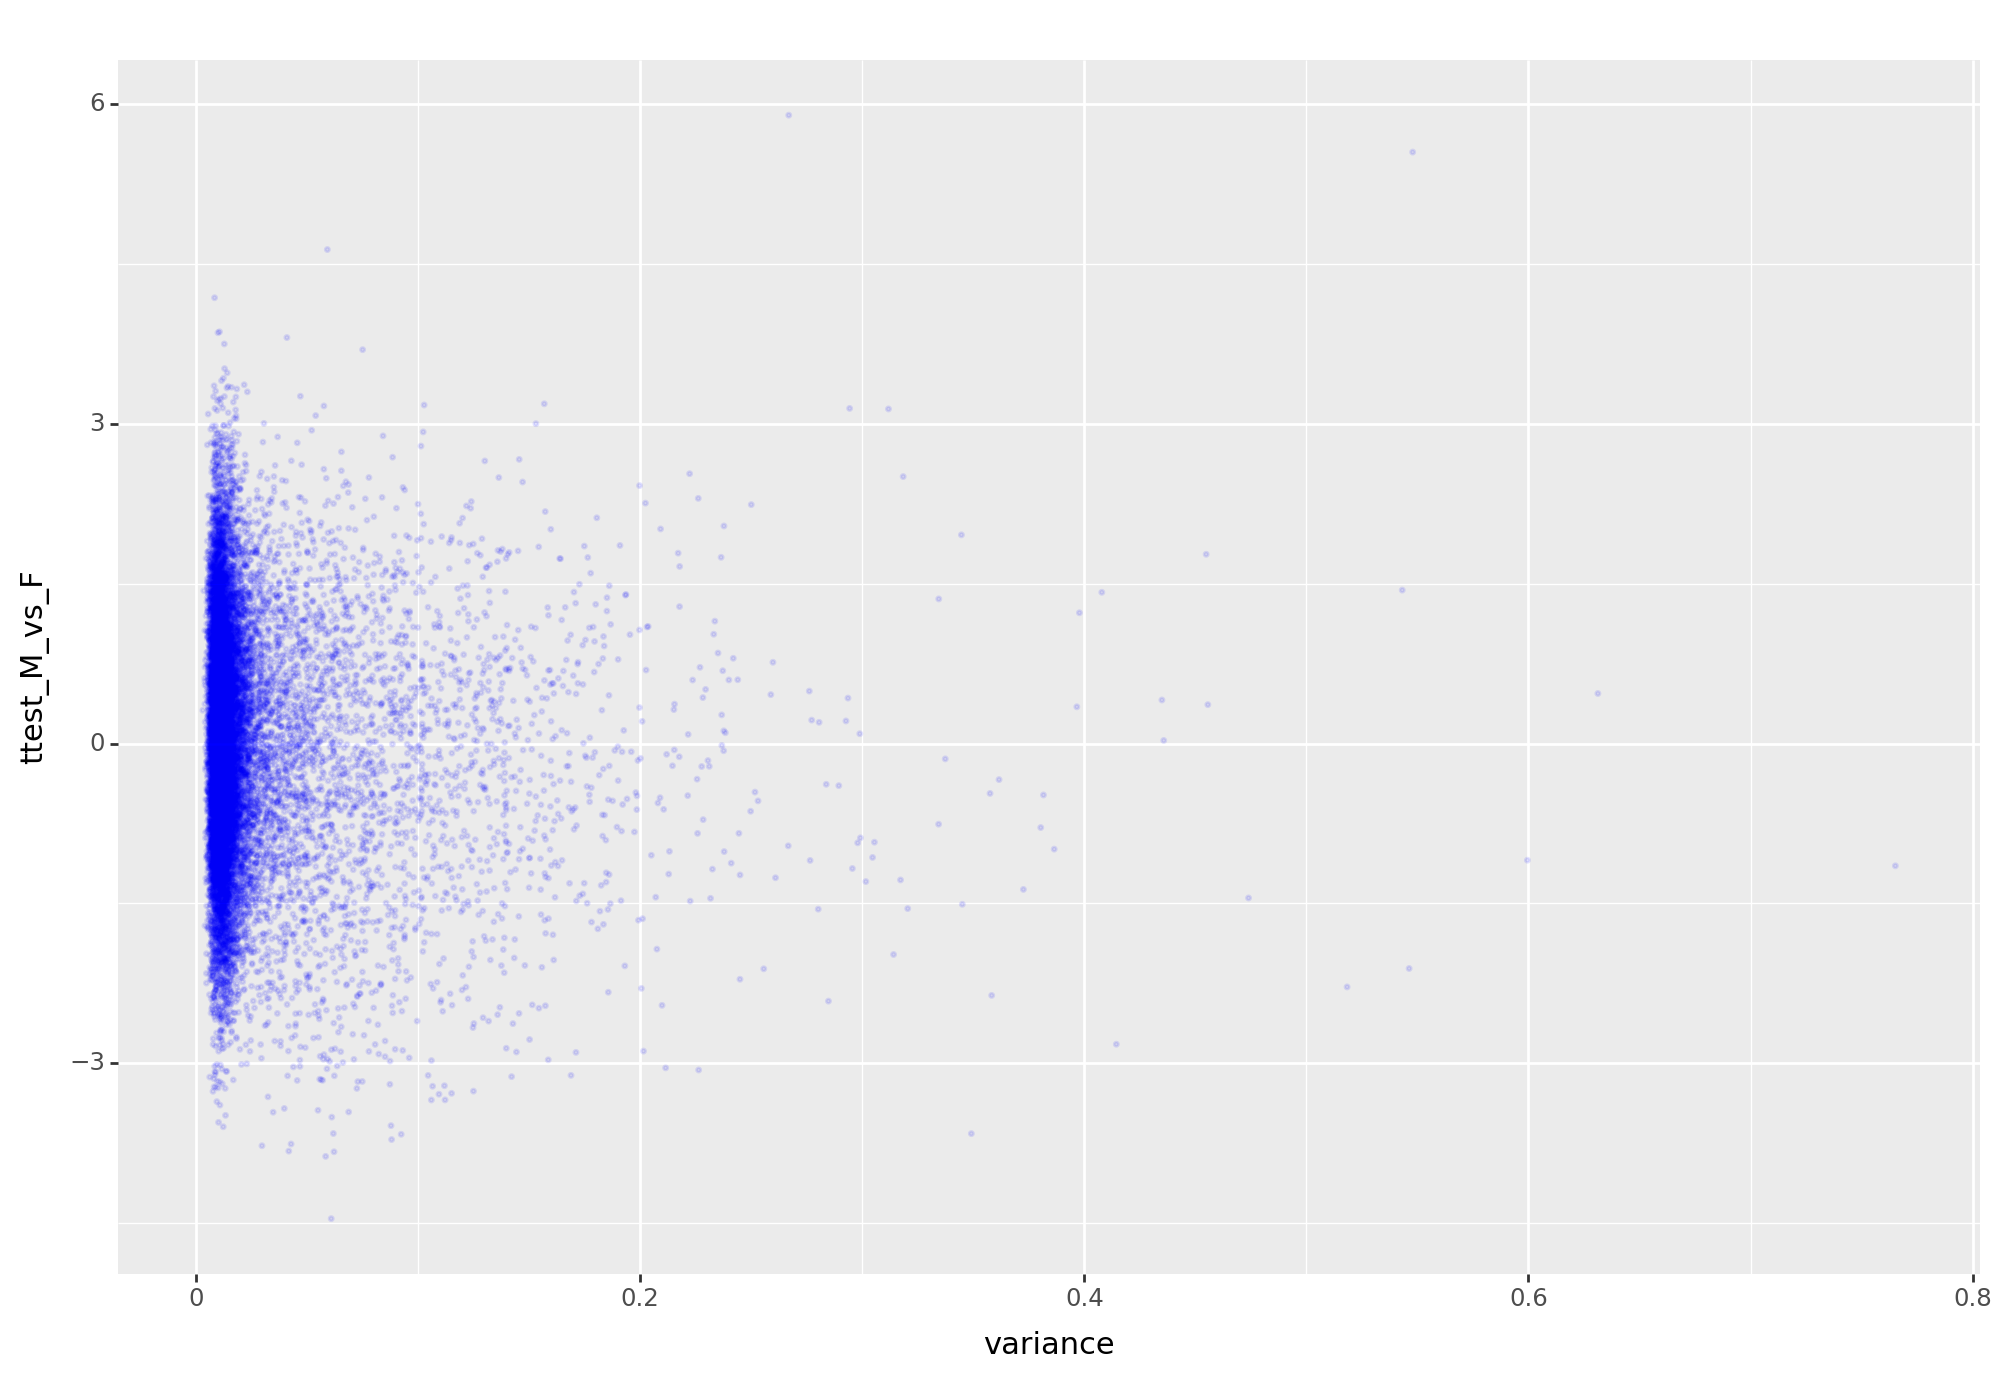

<Figure Size: (1000 x 700)>

In [18]:
# plot male-female ttest versus gene variance
M_vs_F_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_M_vs_F"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
male_vs_female_path = pathlib.Path("./figures/male-female_ttest_vs_variance.png")
M_vs_F_by_variance_plot.save(male_vs_female_path)
M_vs_F_by_variance_plot